## 3 Importando os dados

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import requests
import openai

#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None # default='warn'

from bs4 import BeautifulSoup as bs
from pandas import Series, DataFrame
from datetime import datetime, timedelta
import matplotlib.pylab as plt
import seaborn as sns
import decimal
from decimal import Decimal
import re
plt.style.use('ggplot')

### Importanto informações sobre notas fiscais salvas como csv em load_csv

In [2]:
sales_data = pd.read_csv('./data/csv_files/sales_data.csv')

In [114]:
# Count the rows
row_count = len(sales_data)
print(f"Number of rows: {row_count}")

Number of rows: 18473


Um olhar sobre as primeiras linhas:

In [3]:
sales_data.head()

Data        NF   Est   Pedido      Cliente  \
0  01-06-2007  319203.0  11.0  1223-30       JRIND.   
1  01-06-2007  319202.0  11.0  3350-20       JRIND.   
2  01-06-2007  319187.0  11.0  4737-10        FORMA   
3  01-08-2007  323897.0  11.0  9477-10  ENIOSCARIOT   
4  01-08-2007  323897.0  11.0  9477-20  ENIOSCARIOT   

                           Descrição     Esp        Larg        Comp Preço_pç  \
0   CHAPA GR LTQ DEC 6,30 NBR8300 OL  6,3000  1.200,0000  3.000,0000     0,00   
1       CHAPA FQ DEC 4,25 NBR6658 OL  4,2500  1.200,0000  3.000,0000     0,00   
2           CHAPA FF 0,60 NBR6658 OL  0,6000  1.200,0000  1.850,0000     0,00   
3    CHAPA FQ 2,00 SEGUNDA QUALIDADE  2,0000  1.000,0000  3.000,0000     0,00   
4    CHAPA FQ 2,65 SEGUNDA QUALIDADE  2,6500  1.000,0000  3.000,0000     0,00   

  Preço_kg Quantidade     Total  
0     2,53   1.456,00  3.867,86  
1     2,35   3.081,00  7.602,37  
2     2,85   2.129,00  6.371,03  
3     2,20   1.281,00  2.959,11  
4     2,15     664,00  1.498,98

Um olhar sobre as ultimas linhas:

In [4]:
sales_data.tail()

Data        NF   Est     Pedido     Cliente  \
19811  31-07-2024  349225.0  11.0  376387-20  OMPDOBRASI   
19812  31-07-2024  349224.0  11.0  376928-10    FLANTECH   
19813  31-10-2024  354913.0  11.0  381670-10     MOFERKO   
19814  31-10-2024  354850.0  11.0  381554-20    HIDROJET   
19815  31-10-2024  354912.0  11.0  374971-50    FLANTECH   

                                     Descrição     Esp        Larg  \
19811   CHAPA ZC 1,95 NBR7008 ZC CR MI RV Z100  1,9500  1.200,0000   
19812             CHAPA GR LTQ 6,30 CSN GR A36  6,3000  1.500,0000   
19813         CHAPA GR LTQ 6,30 NBR6656 LNE 38  6,3000  1.200,0000   
19814                CHAPA GR LTQ 9,50 SAE1010  9,5000  1.000,0000   
19815    TIRA ZC BOB 1,25 NBR7008 ZC CR MI REV  1,2500     23,5000   

             Comp Preço_pç Preço_kg Quantidade      Total  
19811  3.000,0000     0,00     7,45   1.628,00  12.522,78  
19812  3.000,0000     0,00     5,99   1.610,00   9.957,33  
19813  3.000,0000     0,00     6,90   4.067,00  28.974,32  
19814  2.630,0000     0,00     6,09   4.715,00  29.647,57  
19815      0,0000     0,00     9,30   3.978,00  38.197,75

Os dados importados abrangem os anos de 2007 a 2024

### Importando informações sobre produtos

In [5]:
products = pd.read_csv('./data/csv_files/products.csv')

In [6]:
products.head()

Descrição Tipo de Produto Comissão Família Produto
0  BLANK CL FF OL 0,75 NBR 6658            BKFF       2%           BLANK
1  BLANK CL FF OL 0,90 NBR 6658            BKFF       2%           BLANK
2  BLANK CL FF OL 1,20 NBR 6658            BKFF       2%           BLANK
3  BLANK CL FF OL 1,50 NBR 6658            BKFF       2%           BLANK
4  BLANK CL FF OL 1,90 NBR 6658            BKFF       2%           BLANK

Como as colunas "Descrição" nos conjuntos de dados **sales_data** e **products** contém o mesmo tipo de informação, serão usadas para mesclar os dois conjuntos de dados a fim de obter informações mais categorizadas sobre os produtos. As colunas "Cod" e "Unnamed" não fazem sentido manter, então as eliminaremos posteriormente.

Inspecionando os tipos de dados em **sales_data**:

In [7]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19816 entries, 0 to 19815
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        19816 non-null  object 
 1   NF          19771 non-null  float64
 2   Est         19771 non-null  float64
 3   Pedido      19771 non-null  object 
 4   Cliente     19771 non-null  object 
 5   Descrição   19771 non-null  object 
 6   Esp         19771 non-null  object 
 7   Larg        19771 non-null  object 
 8   Comp        19771 non-null  object 
 9   Preço_pç    19771 non-null  object 
 10  Preço_kg    19771 non-null  object 
 11  Quantidade  19771 non-null  object 
 12  Total       19771 non-null  object 
dtypes: float64(2), object(11)
memory usage: 2.0+ MB


Serão necessárias algumas alterações nos tipos de dados para realizar uma manipulação adequada dos dados. Por exemplo, o campo "Data", precisa ser convertido para o formato de data e hora (Datetime). À primeira vista, também observamos que a quantidade de valores não nulos é praticamente inexistente em todos os campos do conjunto de dados.

Inspecionando os tipos de dados em **products**:

In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2790 entries, 0 to 2789
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Descrição        2790 non-null   object
 1   Tipo de Produto  2790 non-null   object
 2   Comissão         2790 non-null   object
 3   Família Produto  2790 non-null   object
dtypes: object(4)
memory usage: 87.3+ KB


O campo **"Comissão"** precisa ser convertido para o formato numérico. Os campos **Unnamed** devem ser eliminados.

## 4 Limpeza e Preparação de Dados

Eliminar colunas desnecessárias e atribuir tipos de dados apropriados para garantir cálculos precisos. Isso inclui remover quaisquer valores NaN (ausentes) e verificar duplicatas nos dados.

Ao remover colunas desnecessárias, podemos simplificar o DataFrame e focar apenas nas informações relevantes. Isso ajuda a reduzir a confusão e a melhorar a eficiência das análises subsequentes.

Atribuir tipos de dados apropriados às colunas é importante para garantir cálculos precisos e interpretações significativas. Por exemplo, colunas numéricas devem ser atribuídas aos tipos de dados numéricos corretos (por exemplo, int ou float), colunas de data devem ser atribuídas ao tipo de dados datetime, e colunas categóricas devem ser atribuídas ao tipo de dados categoria.

Remover valores NaN é crucial para garantir que os dados estejam limpos e completos. Valores NaN podem prejudicar cálculos e análises, portanto, é importante lidar com eles adequadamente, seja imputando valores ausentes ou excluindo linhas com dados faltantes, dependendo do contexto específico e dos requisitos.

Verificar duplicatas ajuda a identificar entradas redundantes ou repetidas nos dados. Ao identificar e remover duplicatas, você pode garantir que cada ponto de dados seja único e evitar distorcer os resultados de suas análises.

Ao executar essas etapas nesta fase, termos um DataFrame refinado otimizado para cálculos precisos, análises significativas e insights confiáveis.

#### Converter Data para o formato datetime e verificar valores nulos:

In [9]:
#sales_data ['Data'] = pd.to_datetime(sales_data['Data'])
sales_data['Data'] = pd.to_datetime(sales_data['Data'], format='%d-%m-%Y')
print(sales_data['Data'].isnull().sum())

0


#### Converter Preço_kg para o formato numerico float

In [10]:
#sales_data['Preço_kg'] = sales_data['Preço_kg'].apply(lambda x: float(x.strip().replace(',', '.')))
#sales_data['Preço_kg'] = sales_data['Preço_kg'].apply(lambda x: float(x.strip().replace('None', '0.00')))
#pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display
sales_data['Preço_kg'] = sales_data['Preço_kg'].apply(lambda x: float(str(x).strip().replace(',', '.')) if isinstance(x, str) else x)
sales_data['Preço_kg'] = sales_data['Preço_kg'].apply(lambda x: float(str(x).strip().replace('None', '0.00')) if isinstance(x, str) else x)
print(sales_data['Preço_kg'])

0        2.53
1        2.35
2        2.85
3        2.20
4        2.15
         ... 
19811    7.45
19812    5.99
19813    6.90
19814    6.09
19815    9.30
Name: Preço_kg, Length: 19816, dtype: float64


#### Converter Preço_pç para o formato numerico float

In [11]:
sales_data['Preço_pç'] = sales_data['Preço_pç'].apply(lambda x: float(str(x).strip().replace(',', '.')) if isinstance(x, str) else x)
sales_data['Preço_pç'] = sales_data['Preço_pç'].apply(lambda x: float(str(x).strip().replace('None', '0.00')) if isinstance(x, str) else x)
#pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display
print(sales_data['Preço_pç'])

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19811    0.0
19812    0.0
19813    0.0
19814    0.0
19815    0.0
Name: Preço_pç, Length: 19816, dtype: float64


#### Converter Quantidade para o formato numerico int

In [12]:
#sales_data['Quantidade'] = sales_data['Quantidade'].apply(lambda x: str(x.split()[0].replace('.', '')))
#sales_data['Quantidade'] = sales_data['Quantidade'].apply(lambda x: re.sub(r'(\,\d\d)', '', x))
#sales_data['Quantidade'] = sales_data['Quantidade'].apply(lambda x: int(x.strip().replace('None', '0')))
#sales_data['Quantidade'] = sales_data['Quantidade'].astype(int)
# Convert all values to strings, handle NaN, and clean the data
sales_data['Quantidade'] = sales_data['Quantidade'].fillna('0').astype(str)
sales_data['Quantidade'] = sales_data['Quantidade'].str.replace(r'(\,\d\d)', '', regex=True)
sales_data['Quantidade'] = sales_data['Quantidade'].str.replace('None', '0')
sales_data['Quantidade'] = sales_data['Quantidade'].str.strip().astype(float)

print(sales_data['Quantidade'])

0          1.456
1          3.081
2          2.129
3          1.281
4        664.000
          ...   
19811      1.628
19812      1.610
19813      4.067
19814      4.715
19815      3.978
Name: Quantidade, Length: 19816, dtype: float64


Removendo a coluna **Total** e criando novamento por ser mais simples e direto do que fazer tratamento.

In [13]:
sales_data.drop(['Total'], axis=1, inplace=True)
sales_data['Total'] = sales_data['Preço_kg'] * sales_data['Quantidade']

**Descrição** tem um espaço em branco na frente, que pode causar problemas quando juntar **sales_data** e **products**.

In [14]:
sales_data['Descrição'][0]

' CHAPA GR LTQ DEC 6,30 NBR8300 OL'

Removendo o espaço em branco na frente da **Descrição**.

In [15]:
sales_data['Descrição'] = sales_data['Descrição'].str.lstrip()

In [16]:
sales_data.head()

Data        NF   Est   Pedido      Cliente  \
0 2007-06-01  319203.0  11.0  1223-30       JRIND.   
1 2007-06-01  319202.0  11.0  3350-20       JRIND.   
2 2007-06-01  319187.0  11.0  4737-10        FORMA   
3 2007-08-01  323897.0  11.0  9477-10  ENIOSCARIOT   
4 2007-08-01  323897.0  11.0  9477-20  ENIOSCARIOT   

                          Descrição     Esp        Larg        Comp  Preço_pç  \
0  CHAPA GR LTQ DEC 6,30 NBR8300 OL  6,3000  1.200,0000  3.000,0000       0.0   
1      CHAPA FQ DEC 4,25 NBR6658 OL  4,2500  1.200,0000  3.000,0000       0.0   
2          CHAPA FF 0,60 NBR6658 OL  0,6000  1.200,0000  1.850,0000       0.0   
3   CHAPA FQ 2,00 SEGUNDA QUALIDADE  2,0000  1.000,0000  3.000,0000       0.0   
4   CHAPA FQ 2,65 SEGUNDA QUALIDADE  2,6500  1.000,0000  3.000,0000       0.0   

   Preço_kg  Quantidade       Total  
0      2.53       1.456     3.68368  
1      2.35       3.081     7.24035  
2      2.85       2.129     6.06765  
3      2.20       1.281     2.81820  
4      2.15     664.000  1427.60000

In [113]:
sales_data.tail()

Data  Dia  Mês   Ano        NF      Cliente     Pedido  \
18468 2023-03-21   21    3  2023   81813.0     ACOPLANO  351603-20   
18469 2023-03-31   31    3  2023   81999.0     ACOPLANO  352417-10   
18470 2023-05-22   22    5  2023  326242.0        RALKY  354272-10   
18471 2023-05-22   22    5  2023  326261.0        RALKY  354272-10   
18472 2023-10-31   31   10  2023  334868.0  METMETALCIN  363346-10   

                                    Descrição     Esp        Larg    Comp  \
18468   BOB AL/ZN 0,65 ASTM A792 CN C/TQ ACAB  0,6500  1.200,0000  0,0000   
18469    BOB AL/ZN 0,50 ASTM A792 CN C/TQ ACA  0,5000  1.200,0000  0,0000   
18470  BOB ZC 2,25 BS 10346 HX340 LAD CR MI R  2,2500  1.200,0000  0,0000   
18471  BOB ZC 2,25 BS 10346 HX340 LAD CR MI R  2,2500  1.200,0000  0,0000   
18472      TIRA FF BOB 0,25 G2L290 BbOL SMODI  0,2500     47,0000  0,0000   

        Tipo de Produto Família Produto  Quantidade  Preço_pç  Preço_kg  \
18468  BOBINA GALVALUME          BOBINA       7.290       0.0      8.80   
18469  BOBINA GALVALUME          BOBINA      23.815       0.0      8.80   
18470         BOBINA ZC          BOBINA      11.335       0.0      7.55   
18471         BOBINA ZC          BOBINA      11.340       0.0      7.55   
18472        TFF OL BOB            FITA       2.250       0.0      9.95   

       US_Dollar_in_R$  Preço_KG_USD      Total Comissão  
18468           5.2438      1.678172   64.15200       1%  
18469           5.0798      1.732352  209.57200       1%  
18470           4.9674      1.519910   85.57925       1%  
18471           4.9674      1.519910   85.61700       1%  
18472           5.0569      1.967609   22.38750       2%

In [17]:
products.head()

Descrição Tipo de Produto Comissão Família Produto
0  BLANK CL FF OL 0,75 NBR 6658            BKFF       2%           BLANK
1  BLANK CL FF OL 0,90 NBR 6658            BKFF       2%           BLANK
2  BLANK CL FF OL 1,20 NBR 6658            BKFF       2%           BLANK
3  BLANK CL FF OL 1,50 NBR 6658            BKFF       2%           BLANK
4  BLANK CL FF OL 1,90 NBR 6658            BKFF       2%           BLANK

Mesclando **sales_data** e **products** em um único DataFrame.

In [18]:
sales_data = pd.merge(sales_data, products)

## 5 Web Scraping

Vamos analisar a possível correlação entre o preço do Dólar e a variação nos preços dos materiais, para isso é necessário importar a série histórica das flutuações da taxa de câmbio do Dólar em Reais.

Start Web Scraping:

In [19]:
r = requests.get("http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38590&module=M")

Usar dados salvos em caso de economizar processamento:

In [20]:
dollar_df = pd.read_csv('./data/csv_files/dollar.csv')

Convert to a beautiful soup object:

In [55]:
soup = bs(r.content)
soup.prettify()

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n <head>\n  <script data-dtconfig="rid=RID_514660424|rpid=228916670|domain=ipeadata.gov.br|reportUrl=/rb_8d61458e-426f-4d44-a138-2d66bd9a76ef|app=ea7c4b59f27d43eb|srms=1,1,,,|uxrgcm=100,25,300,3;100,25,300,3|featureHash=ICA2SVfqru|dpvc=1|lastModification=1579894847177|dtVersion=10183200114120852|tp=500,50,0,1|rdnt=1|uxrgce=1|uxdcw=1500|bp=2|agentUri=/ruxitagentjs_ICA2SVfqru_10183200114120852.js" src="/ruxitagentjs_ICA2SVfqru_10183200114120852.js" type="text/javascript">\n  </script>\n  <link href="/DXR.axd?r=1_14,1_16,10_0,1_11,1_10,1_1,1_7,1_8,1_6-JQ0Ub" rel="stylesheet" type="text/css"/>\n  <title>\n   Ipeadata\n  </title>\n  <link href="css/estilos.css" rel="stylesheet" type="text/css"/>\n </head>\n <body>\n  <form action="./ExibeSerie.aspx?serid=38590&amp;module=M" id="frm" method="post" name="frm">\n   <input id="__

Mesmo ao usar 'soup.prettify()', que adiciona indentação e quebras de linha, ainda é difícil visualizar a estrutura da página. No entanto, os dados que estamos buscando estão estruturados na forma de uma tabela, como mostrado abaixo.
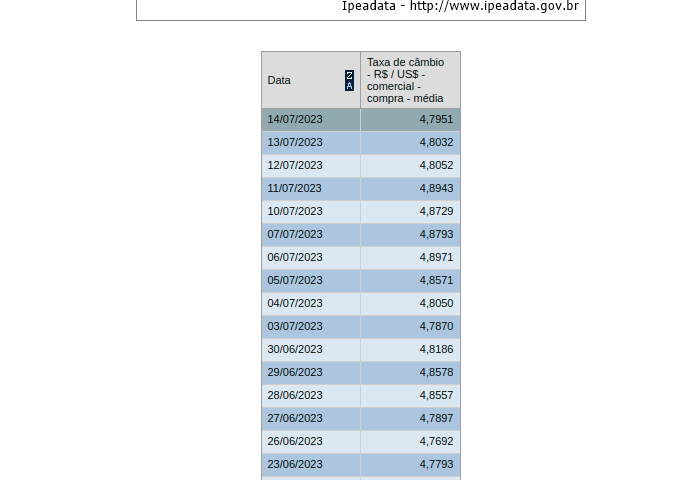

 Ao inspecionar a tabela, é evidente que os dados que estamos buscando, data e valor, são inseridos dentro das tags **<tr></tr>** com um ID que segue o padrão id="grd_DXDataRow0", onde "Rows0" no final indica os dados mais recentes.

Portanto, podemos criar uma função que busca por esse padrão de ID dentro das tags **<tr></tr>** dentro do objeto soup e, em seguida, coleta os dados dentro de cada tag **<td></td>**.

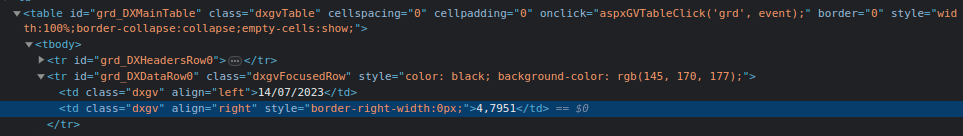

Para definir o intervalo de dados a ser extraído da web, podemos assumir que o campo **"Data"** de **sales_data** está em ordem cronológica. 

Podemos começar identificando a data da primeira ocorrência. Em seguida, calculamos a diferença no número de dias entre a última ocorrência e a data de hoje. Essa diferença calculada servirá como o intervalo para a extração de dados na web, garantindo que apenas os dados dentro desse período específico sejam coletados.

In [56]:
first_date  = pd.to_datetime(sales_data ['Data'].iloc[0]).date()
today = datetime.today().date()
range_date = (today - first_date).days
print(f' Today is: {today}')
print(f' The first date in the dataset is: {first_date}')
print(f' The range_date is: {range_date}')

 Today is: 2024-12-12
 The first date in the dataset is: 2007-06-01
 The range_date is: 6404


Agora podemos definir uma função que recupera os valores do dólar dentro do período de tempo especificado e retorna um DataFrame com os valores do dólar e as datas em formato datetime. 

Para realizar essa pesquisa, a função assume um padrão de ID fixo no HTML e incrementa a parte final do ID, que representa cada linha da tabela, em cada iteração do loop.

In [57]:
def get_dollar_value():
    date = []
    value = []
    for id in range((range_date)):
        id = str(id)
        pattern = 'grd_DXDataRow' + id
        id = int(id)
        
        # It searches for the first <tr> element that has an id attribute matching the pattern 
        tr =  soup.find('tr', {'id' : pattern})
        
        # retrieves all the <td> (table cell) elements within a specific <tr> (table row) element.
        t_data_tags = tr.find_all("td")
        date.append(t_data_tags[0].text)
        value.append(t_data_tags[1].text)
        date[id] = datetime.strptime(date[id], '%d/%m/%Y')
        if (date[id]) == first_date:
            break
    data = {'Data': date, 'US_Dollar_in_R$': value}
    dollar_df = pd.DataFrame(data)
 
    return dollar_df

Obtendo valores do dólar:

In [58]:
dollar_df = get_dollar_value()

In [25]:
dollar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6031 entries, 0 to 6030
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Data             6031 non-null   object
 1   US_Dollar_in_R$  6031 non-null   object
dtypes: object(2)
memory usage: 94.4+ KB


Converter **Data** para o formato datetime e verificar valores nulos:

In [26]:
dollar_df['Data'] = pd.to_datetime(dollar_df['Data'])
print(sales_data['Data'].isnull().sum())

0


Converter **US_Dollar_in_R$** para o formato float e verificar valores nulos:

In [67]:
dollar_df['US_Dollar_in_R$'] = dollar_df['US_Dollar_in_R$'].apply(lambda x: str(x.split()[0].replace(',', '.')))
dollar_df['US_Dollar_in_R$'] = dollar_df['US_Dollar_in_R$'].astype(float)
print(dollar_df['US_Dollar_in_R$'].isnull().sum())

0


Salvando valores do como csv:

In [68]:
dollar_df.to_csv('./data/csv_files/dollar.csv', index =False)

In [69]:
dollar_df.head()

Data  US_Dollar_in_R$
0 2024-12-11           6.0314
1 2024-12-10           6.0523
2 2024-12-09           6.0564
3 2024-12-06           6.0287
4 2024-12-05           5.9843

In [70]:
dollar_df.tail()

Data  US_Dollar_in_R$
6399 1999-05-28           1.7303
6400 1999-05-27           1.7129
6401 1999-05-26           1.7178
6402 1999-05-25           1.7472
6403 1999-05-24           1.6977

In [71]:
dollar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             6404 non-null   datetime64[ns]
 1   US_Dollar_in_R$  6404 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 100.2 KB


Mesclando **sales_data** e **dollar_df** em um único DataFrame.

In [65]:
print(sales_data.dtypes)


Data               datetime64[ns]
Dia                         int64
Mês                         int64
Ano                         int64
NF                        float64
Cliente                    object
Pedido                     object
Descrição                  object
Esp                        object
Larg                       object
Comp                       object
Tipo de Produto            object
Família Produto            object
Quantidade                float64
Preço_pç                  float64
Preço_kg                  float64
US_Dollar_in_R$           float64
Preço_KG_USD              float64
Total                     float64
Comissão                   object
dtype: object
Data               datetime64[ns]
US_Dollar_in_R$            object
dtype: object


In [66]:
print(dollar_df.dtypes)

Data               datetime64[ns]
US_Dollar_in_R$            object
dtype: object


In [72]:
sales_data = pd.merge(sales_data, dollar_df)

Checando valores NaN:

In [73]:
sales_data.isna().sum()

Data               0
Dia                0
Mês                0
Ano                0
NF                 0
Cliente            0
Pedido             0
Descrição          0
Esp                0
Larg               0
Comp               0
Tipo de Produto    0
Família Produto    0
Quantidade         0
Preço_pç           0
Preço_kg           0
US_Dollar_in_R$    0
Preço_KG_USD       0
Total              0
Comissão           0
dtype: int64

In [74]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18473 entries, 0 to 18472
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             18473 non-null  datetime64[ns]
 1   Dia              18473 non-null  int64         
 2   Mês              18473 non-null  int64         
 3   Ano              18473 non-null  int64         
 4   NF               18473 non-null  float64       
 5   Cliente          18473 non-null  object        
 6   Pedido           18473 non-null  object        
 7   Descrição        18473 non-null  object        
 8   Esp              18473 non-null  object        
 9   Larg             18473 non-null  object        
 10  Comp             18473 non-null  object        
 11  Tipo de Produto  18473 non-null  object        
 12  Família Produto  18473 non-null  object        
 13  Quantidade       18473 non-null  float64       
 14  Preço_pç         18473 non-null  float

Houve uma variação no volume de dados em **sales_data** . Primeiramente, tínhamos 19139 linhas, após mesclar com **products** ficamos com 19840 linhas em todos os campos,  e finalmente após mesclar com **dollar_df** obtivemos 19197. 

Essa variação no número de linhas pode ser atribuída à duplicação de valores após a mesclagem com a tabela de produtos. É essencial abordar esse problema no futuro para garantir a integridade dos dados no banco de dados do nosso sistema.

Podemos usar as colunas **Pedido** e **Quantidade** como identificadores de valores duplicados já que mais de uma ocorrência repetida destes dois valores pode representar a presença de entradas duplicadas no conjunto de dados.

In [75]:
duplicates = sales_data.duplicated(subset=['NF','Pedido','Cliente','Quantidade'], keep = False)

# Filter the original DataFrame to show only the duplicate rows
duplicate_rows = sales_data[duplicates]

for index, row in duplicate_rows.iterrows():
    print(f'Original:{row["NF"]} -  {row["Cliente"]} - {row["Pedido"]} - {row["Quantidade"]}, Duplicated:{row["NF"]} - {row["Cliente"]} {row["Pedido"]} - {row["Quantidade"]}')

print(f'The number of duplicates is: {duplicates.sum()}')
#duplicates.head()


The number of duplicates is: 0


In [36]:
duplicate_rows.head()

Data        NF   Est    Pedido   Cliente  \
129 2007-06-19  320336.0  11.0   4653-10  REVALIND   
130 2007-06-19  320336.0  11.0   4653-10  REVALIND   
265 2008-03-12      72.0  14.0  22958-10   COPRIMA   
266 2008-03-12      72.0  14.0  22958-10   COPRIMA   
313 2008-01-29  336385.0  11.0  18788-20  REVALIND   

                             Descrição     Esp      Larg        Comp  \
129  TR REL 1,20 BOB NBR5007 G4RL BbOL  1,2000   59,0000      0,0000   
130  TR REL 1,20 BOB NBR5007 G4RL BbOL  1,2000   59,0000      0,0000   
265               TIRA FQ 3,00 NBR6658  3,0000  100,0000  1.200,0000   
266               TIRA FQ 3,00 NBR6658  3,0000  100,0000  1.200,0000   
313  TR REL 1,20 BOB NBR5007 G4RL BbOL  1,2000   59,0000      0,0000   

     Preço_pç  Preço_kg  Quantidade       Total Tipo de Produto Comissão  \
129       0.0      3.55       2.353     8.35315        TIRA REL       2%   
130       0.0      3.55       2.353     8.35315        TIRA REL       2%   
265       0.0      2.57     548.000  1408.36000             TFQ       2%   
266       0.0      2.57     548.000  1408.36000             TFQ       2%   
313       0.0      3.55       2.299     8.16145        TIRA REL       2%   

    Família Produto  US_Dollar_in_R$  
129      RELAMINADO           1.9100  
130      RELAMINADO           1.9100  
265    TIRA CORTADA           1.6788  
266    TIRA CORTADA           1.6788  
313      RELAMINADO           1.7754

In [76]:
# Drop the duplicates and assign the result back to final_df
sales_data = sales_data.drop_duplicates(subset=['NF','Pedido','Cliente','Quantidade']).reset_index(drop = True)

# Check for duplicates and print the number of duplicates
duplicates = sales_data.loc[sales_data.duplicated(subset=['NF','Pedido','Cliente','Quantidade'])]
print(f'The number of duplicates is: {sales_data.duplicated(subset=["NF","Pedido","Cliente","Quantidade"]).sum()}')

# Display the duplicates (if any)
print(duplicates)

The number of duplicates is: 0
Empty DataFrame
Columns: [Data, Dia, Mês, Ano, NF, Cliente, Pedido, Descrição, Esp, Larg, Comp, Tipo de Produto, Família Produto, Quantidade, Preço_pç, Preço_kg, US_Dollar_in_R$, Preço_KG_USD, Total, Comissão]
Index: []


Duplicadas removidas!

Agora, criaremos colunas separadas para **dia**, **mês** e **ano** a partir da coluna **'Data'** que serão  usadas para agrupar dados.

Será criada a coluna 'Preço_KG_USD' que indicará o preço por quilo em Dólares.

Essas operações realizadas no DataFrame terão as seguintes implicações:

- A criação das colunas **'Dia'**, **'Mês'** e **'Ano'** permite uma melhor organização e análise dos dados com base nesses componentes temporais. Isso possibilita agrupar e extrair insights em um nível granular, como tendências de vendas por dia, mês ou ano.

- A criação da coluna 'Price_KG_USD' oferece uma perspectiva adicional sobre preços, convertendo o preço por quilo de Real Brasileiro para Dólares Americanos (USD/Kg). Essa conversão facilita comparações com mercados internacionais e permite a análise de diferenciais de preço e competitividade.

- Finalmente, a reorganização das colunas no DataFrame ajuda a melhorar a legibilidade e garante que as colunas estejam organizadas de acordo com a ordem desejada especificada no código. Isso pode ser útil para uma interpretação mais fácil dos dados e análises subsequentes.


In [77]:
# Create a day column and Get the day from Date
sales_data['Dia'] = sales_data['Data'].dt.day.astype(int)

# Create a Month column and Get the month from Date
sales_data['Mês'] = (sales_data['Data'].dt.month).astype(int)

# Create a Year column and get the year from Date
sales_data['Ano'] = sales_data['Data'].dt.year.astype(int)

# Create a Column for USD/kg price by converting the R$/Kg Price as USD/Kg Price 
sales_data['Preço_KG_USD'] = sales_data['Preço_kg'] / sales_data['US_Dollar_in_R$']

# Reorder the columns
sales_data= pd.DataFrame(sales_data, columns=["Data",'Dia','Mês','Ano','NF','Cliente','Pedido',"Descrição",
                               'Esp','Larg','Comp','Tipo de Produto','Família Produto',
                               'Quantidade','Preço_pç','Preço_kg','US_Dollar_in_R$','Preço_KG_USD','Total','Comissão'
                              ])

sales_data.loc[0:1]

Data  Dia  Mês   Ano        NF Cliente   Pedido  \
0 2007-06-01    1    6  2007  319203.0  JRIND.  1223-30   
1 2007-06-01    1    6  2007  319202.0  JRIND.  3350-20   

                          Descrição     Esp        Larg        Comp  \
0  CHAPA GR LTQ DEC 6,30 NBR8300 OL  6,3000  1.200,0000  3.000,0000   
1      CHAPA FQ DEC 4,25 NBR6658 OL  4,2500  1.200,0000  3.000,0000   

      Tipo de Produto Família Produto  Quantidade  Preço_pç  Preço_kg  \
0  CHAPA GR LTQ DECOL           CHAPA       1.456       0.0      2.53   
1          CFQ DEC OL           CHAPA       3.081       0.0      2.35   

   US_Dollar_in_R$  Preço_KG_USD    Total Comissão  
0           1.9048      1.328223  3.68368       1%  
1           1.9048      1.233725  7.24035       1%

A ideia agora é extrair determinados valores em variáveis para que possam ser usados para calcular métricas e visualizar a distribuição dos valores posteriormente.

Em resumo, pretendemos fazer o seguinte:

1. Extrair os valores únicos da coluna **'Dia'** e armazená-los na variável **'dias'**. Esta lista representará a ordem cronológica dos dias e pode ser usada para analisar o montante de vendas em cada dia.

2. Extrair os valores únicos da coluna **'Mês'** e armazená-los na variável **'meses'**. Esta lista representará a ordem cronológica dos meses e pode ser usada para analisar o montante de vendas mensalmente.

3. Extrair os valores únicos da coluna **'Ano'** e armazená-los na variável **'anos'**. Esta lista representará a ordem cronológica dos anos e pode ser usada para analisar o montante de vendas anualmente.

4. Recuperar os valores das colunas **'Quantidade'**, **'Esp'**, **'Larg'** e **'Preços'**. Essas listas de quantidades, espessuras, larguras e preços podem ser usadas para análises ou cálculos adicionais.

Essas operações permitem a extração de valores únicos de colunas específicas, possibilitando análises com base em dias, meses e anos. Além disso, os valores de outras colunas podem ser usados para diversos fins, como calcular estatísticas ou realizar análises adicionais no conjunto de dados.

In [78]:
# To obtain a list of days in chronological order, we can extract the unique values from the 'Day' column. 
dias = (sales_data['Dia'].unique()).astype(int)
dias.sort()
dias

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [79]:
# To obtain a list of months in chronological order, we can extract the unique values from the 'Month' column. 
meses = (sales_data['Mês'].unique()).astype(int)
meses.sort()
meses

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [81]:
# To obtain a list of years in chronological order, we can extract the unique values from the 'Year' column. 
anos = (sales_data['Ano'].unique()).astype(int)
anos.sort()
anos

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023])

In [82]:
quantidades = (sales_data['Quantidade'])

In [83]:
espessuras = (sales_data['Esp'].unique())
espessuras.sort()
espessuras

array(['0,2500', '0,2700', '0,3000', '0,3300', '0,3500', '0,4000',
       '0,4300', '0,4500', '0,4700', '0,4900', '0,5000', '0,5500',
       '0,6000', '0,6500', '0,7000', '0,7500', '0,8000', '0,8100',
       '0,9000', '0,9500', '1,0000', '1,0600', '1,1100', '1,2000',
       '1,2100', '1,2400', '1,2500', '1,5000', '1,5500', '1,6000',
       '1,8000', '1,9000', '1,9500', '10,0000', '11,2000', '12,5000',
       '14,0000', '150,0000', '16,0000', '19,0000', '2,0000', '2,2500',
       '2,3000', '2,5000', '2,6500', '2,7000', '2,9900', '22,4000',
       '25,0000', '3,0000', '3,3500', '3,5000', '3,7500', '31,5000',
       '37,5000', '4,0000', '4,2500', '4,7400', '4,7500', '44,5000',
       '50,0000', '6,3000', '6,3500', '63,0000', '75,0000', '8,0000',
       '89,0000', '9,0000', '9,5000'], dtype=object)

In [84]:
larguras = (sales_data['Larg'].unique())
larguras.sort()
larguras

array(['0,0000', '1.000,0000', '1.045,0000', '1.060,0000', '1.080,0000',
       '1.100,0000', '1.120,0000', '1.132,0000', '1.140,0000',
       '1.150,0000', '1.200,0000', '1.220,0000', '1.245,0000',
       '1.250,0000', '1.300,0000', '1.400,0000', '1.500,0000',
       '1.800,0000', '100,0000', '101,0000', '101,5000', '102,0000',
       '103,0000', '104,0000', '105,0000', '106,0000', '107,0000',
       '11,0000', '110,0000', '111,0000', '111,5000', '112,0000',
       '113,0000', '115,0000', '116,0000', '118,0000', '119,0000',
       '12,0000', '12,5000', '120,0000', '121,0000', '122,0000',
       '122,8000', '124,0000', '125,0000', '127,0000', '128,0000',
       '130,0000', '132,0000', '138,0000', '139,0000', '14,0000',
       '140,0000', '140,5000', '142,0000', '145,0000', '145,8000',
       '147,0000', '148,0000', '149,5000', '15,0000', '150,0000',
       '155,0000', '157,0000', '16,0000', '160,0000', '161,0000',
       '162,0000', '165,0000', '166,0000', '17,0000', '170,0000',
      

Agora temos um DataFrame bem formatado com dados suficientes do período especificado que podem ser mesclados com outros conjuntos de dados.

# 6 Questionando e analisando os dados.

Qual é a estatistica Descritiva dos principais dados numéricos?

In [85]:
stats = sales_data.describe()[['Preço_kg','Preço_KG_USD', 'US_Dollar_in_R$','Quantidade', 'Total']]
stats

Preço_kg  Preço_KG_USD  US_Dollar_in_R$    Quantidade         Total
count  18473.000000  18473.000000      18473.00000  18473.000000  18473.000000
mean       4.280333      1.513423          2.85312    149.430848    641.920757
min        1.900000      0.550728          1.53370      1.000000      2.050000
25%        2.750000      1.159463          1.83900      1.570000      5.959620
50%        3.420000      1.431117          2.32180      2.861000     10.843840
75%        4.680000      1.776909          3.72240      9.735000     38.762780
max       17.880000      4.553903          5.93660    999.000000  16759.260000
std        2.493915      0.482698          1.17427    295.226155   1516.181358

Text(0.5, 0, 'Preço_kg')

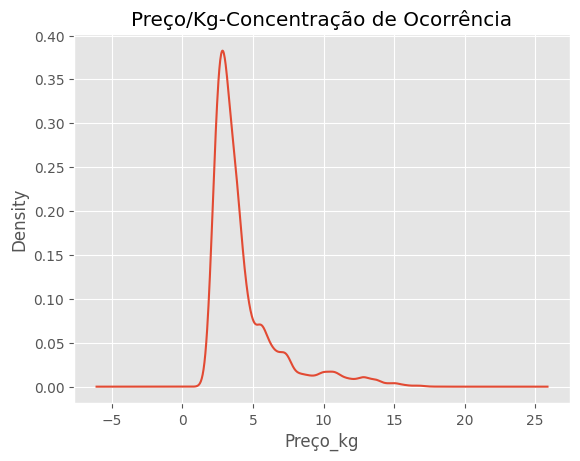

In [86]:
price_view = sales_data['Preço_kg'].plot(kind = 'kde', title= 'Preço/Kg-Concentração de Ocorrência')
price_view.set_xlabel('Preço_kg')

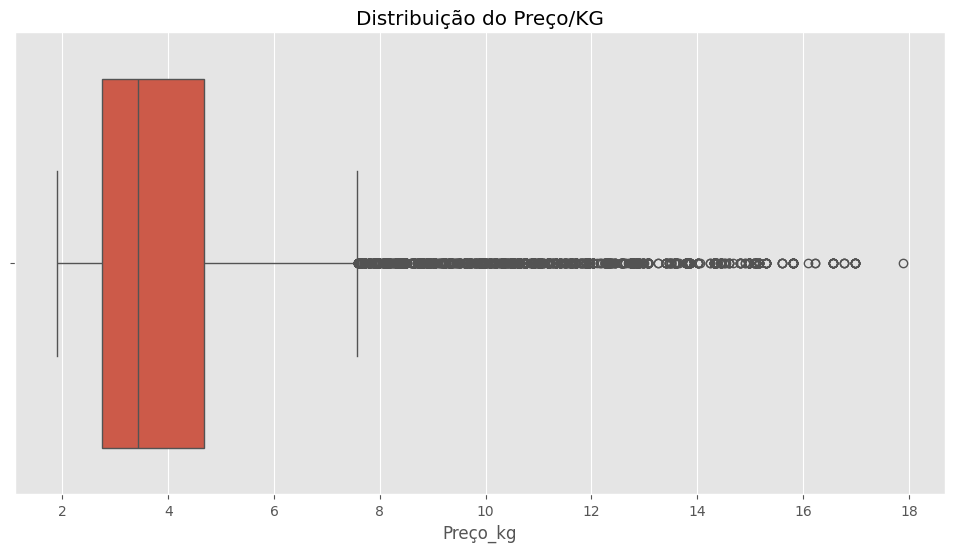

In [87]:
# Pricing Visualization (box plots)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Preço_kg', data=sales_data)
plt.title('Distribuição do Preço/KG')
plt.show()

Text(0, 0.5, 'Contagem')

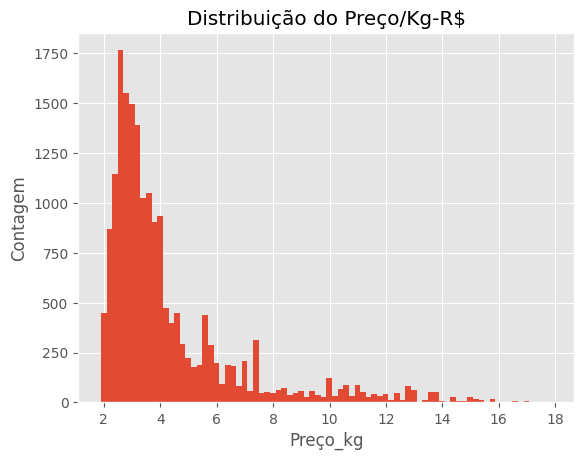

In [88]:
price_view = sales_data['Preço_kg'].plot(kind = 'hist', bins = 80, title= 'Distribuição do Preço/Kg-R$')
price_view.set_xlabel('Preço_kg')
price_view.set_ylabel('Contagem')

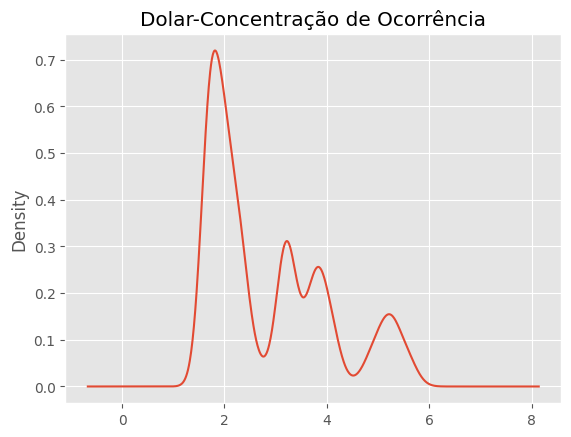

In [89]:
dollar_view = sales_data['US_Dollar_in_R$'].plot(kind = 'kde', title= 'Dolar-Concentração de Ocorrência')

Text(0, 0.5, 'Contagem')

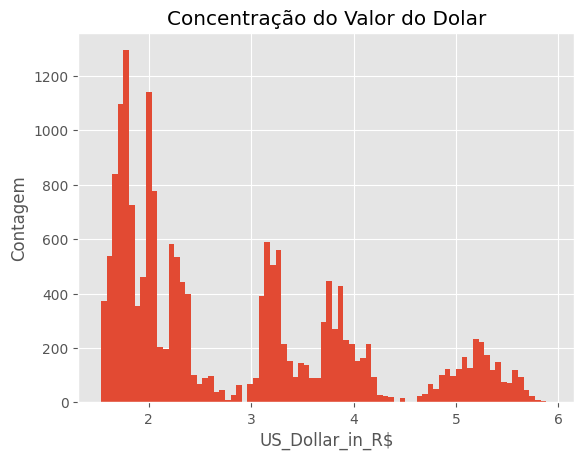

In [90]:
dollar_view = sales_data['US_Dollar_in_R$'].plot(kind = 'hist', bins = 80, title= 'Concentração do Valor do Dolar')

dollar_view.set_xlabel('US_Dollar_in_R$')
dollar_view.set_ylabel('Contagem')

Qual é correlação entre o preço dos materiais e a variação do preço do dólar?

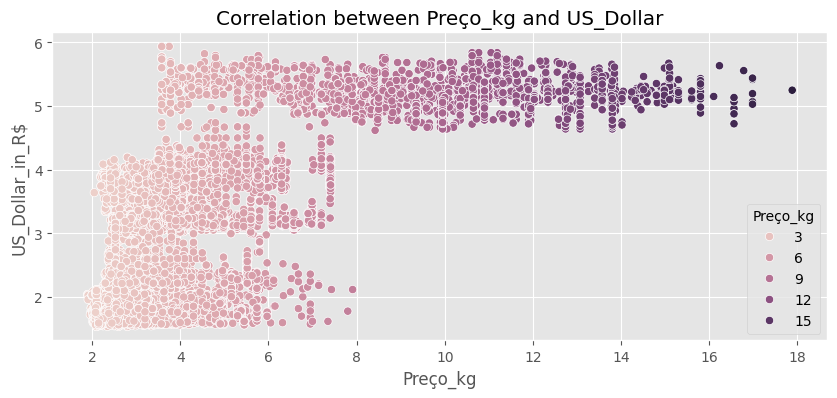

In [91]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=sales_data, x='Preço_kg', y='US_Dollar_in_R$', hue='Preço_kg')
plt.xlabel('Preço_kg')
plt.ylabel('US_Dollar_in_R$')
plt.title('Correlation between Preço_kg and US_Dollar')
plt.show()

Qual é a correlação entre as demais variáveis?

In [92]:
correlation_matrix = sales_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'JRIND.'

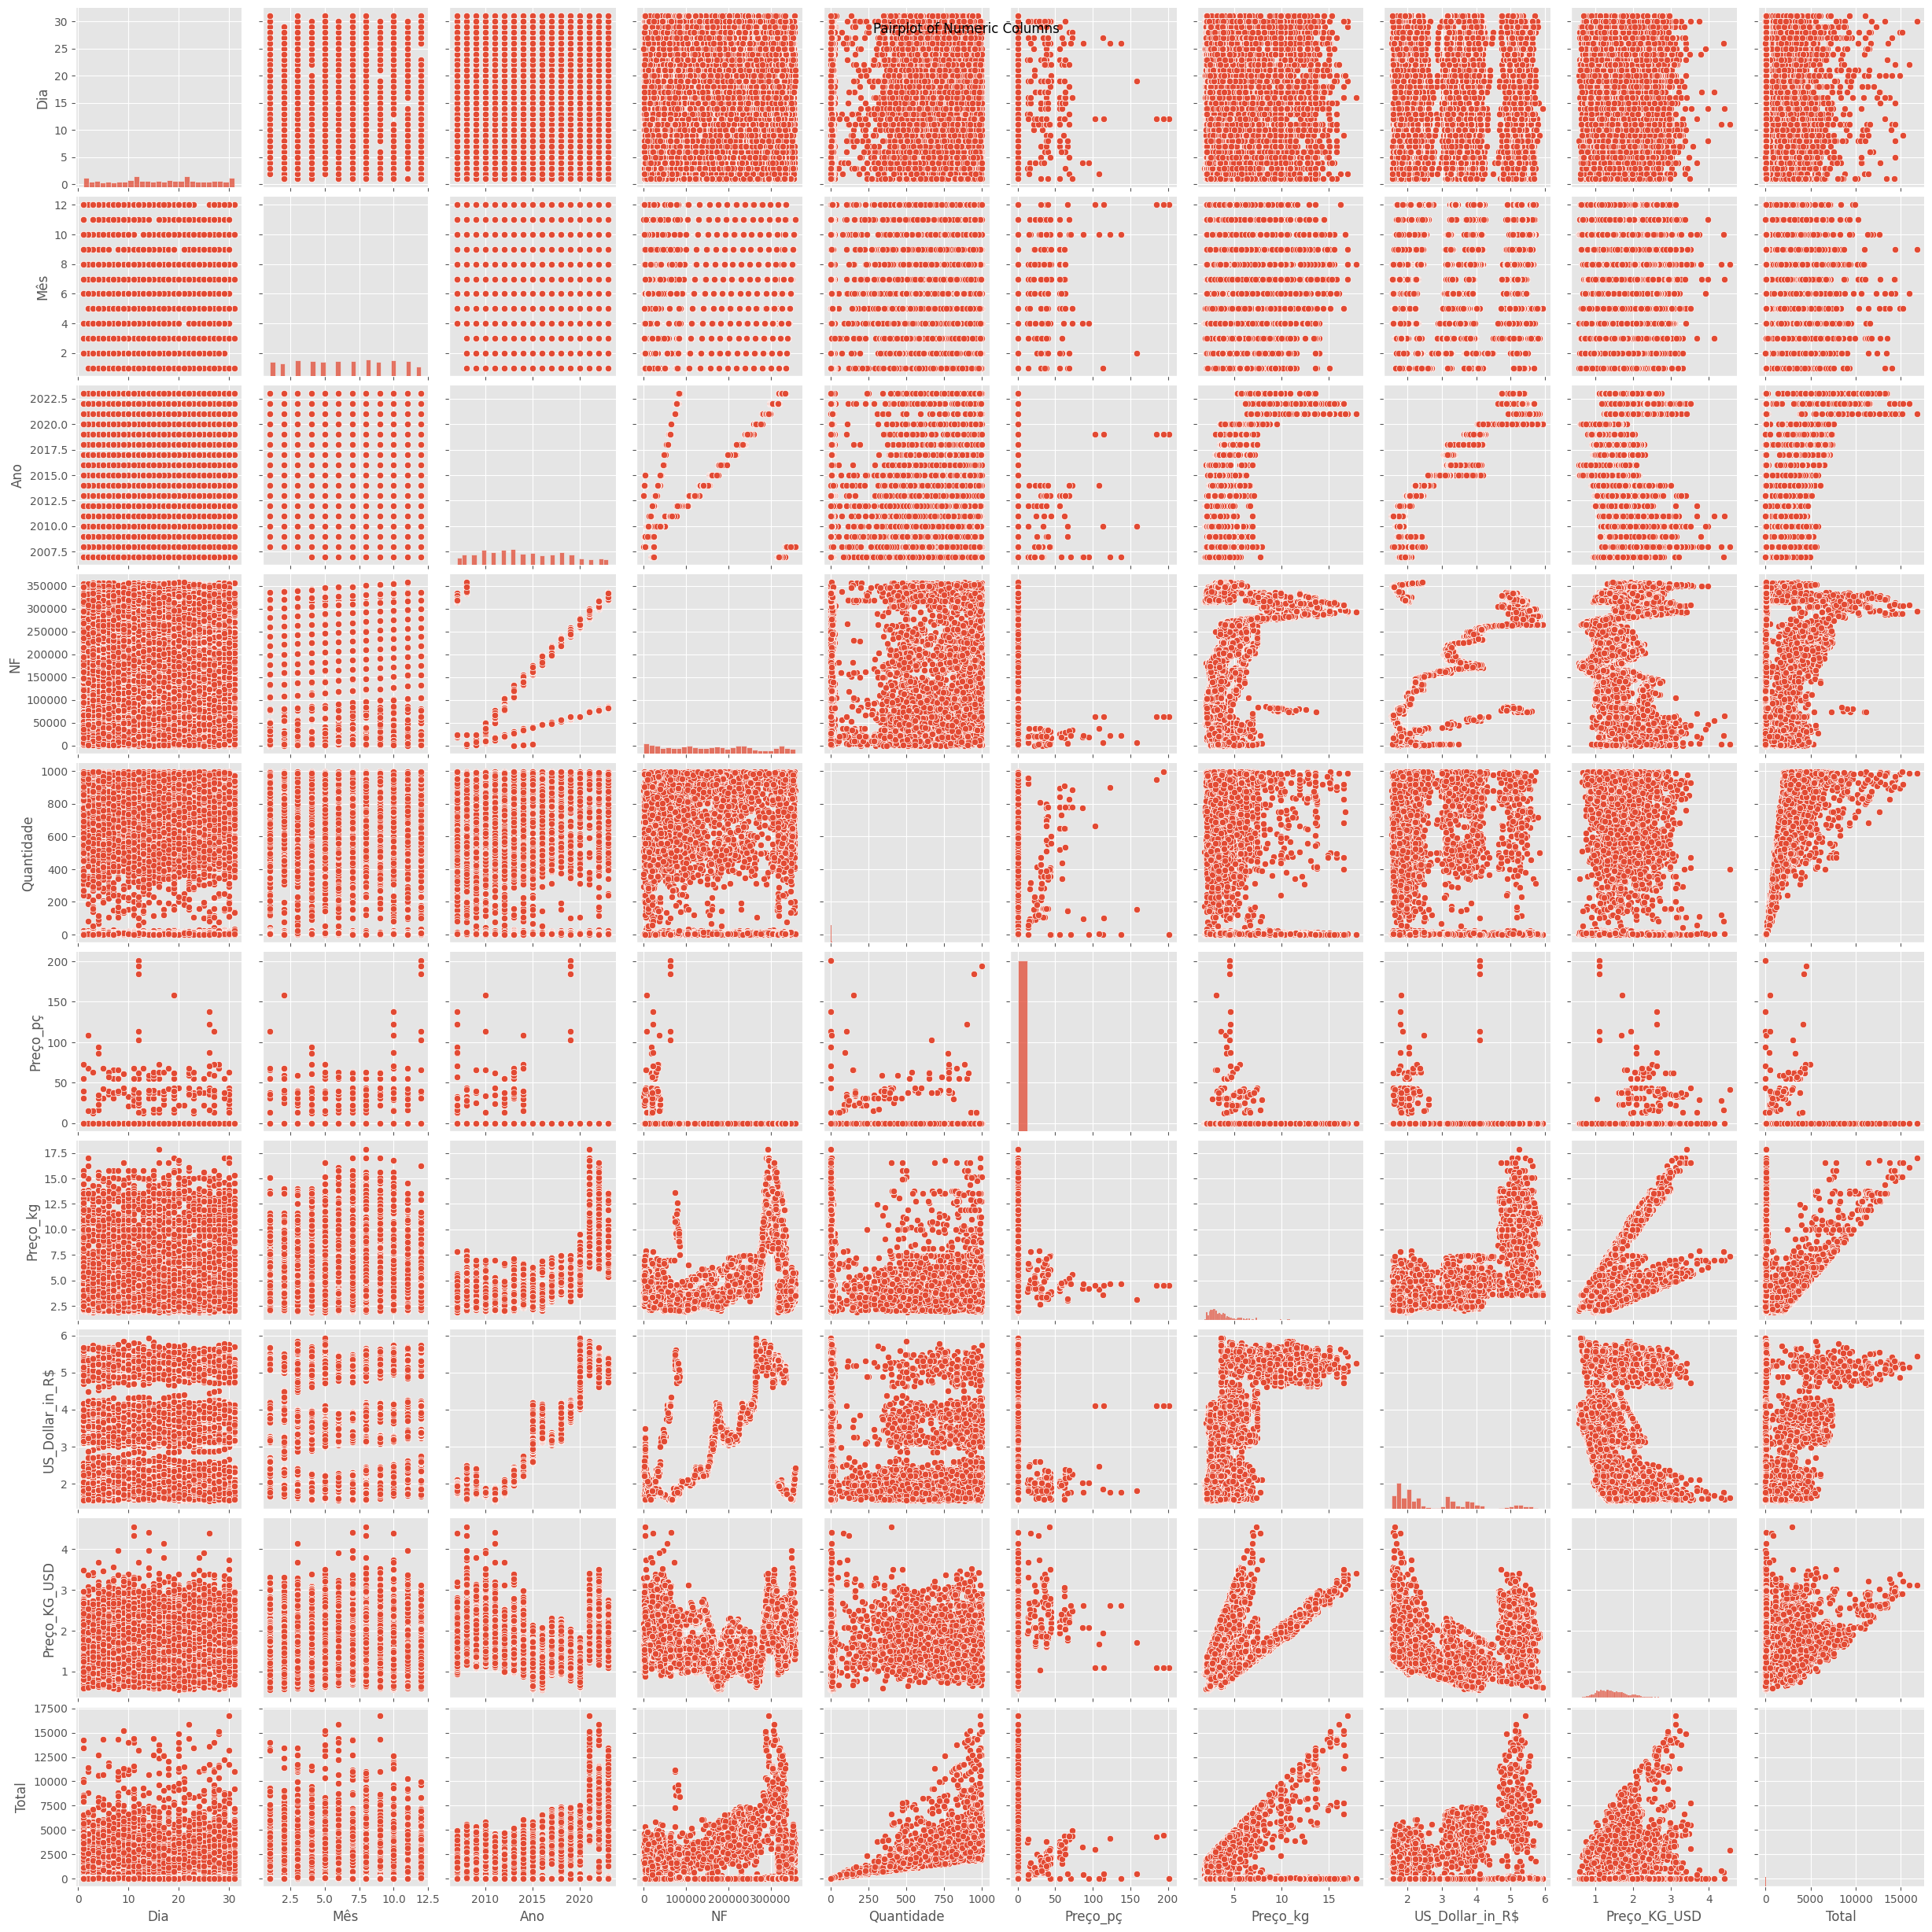

In [93]:
numeric_columns = sales_data.select_dtypes(include=['float64', 'int64'])
sns.pairplot(numeric_columns)
plt.suptitle('Pairplot of Numeric Columns')
plt.show()

Como é variação de preço por Tipo de Produto?

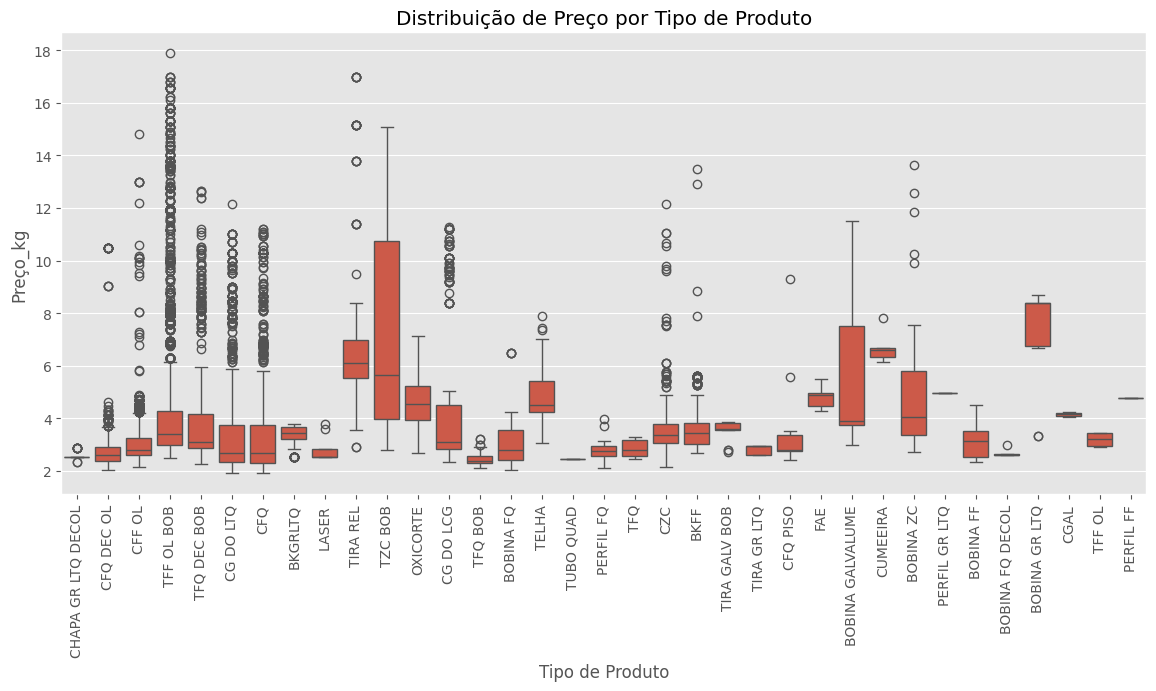

In [94]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Tipo de Produto', y='Preço_kg', data=sales_data)
plt.title('Distribuição de Preço por Tipo de Produto')
plt.xticks(rotation=90)
plt.show()

Qual é menor e maior preço por família de Produto?

In [95]:
min_max_data = product_group['Preço_kg'].agg([min, max])
# Reset the index to make the columns as regular columns
min_max_data = min_max_data.reset_index()
min_max_data

NameError: name 'product_group' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(min_max_data['Família Produto'], min_max_data['min'], label='Minimum Price', color='blue' )
plt.plot(min_max_data['Família Produto'], min_max_data['max'], label='Maximum Price', color='green')
plt.xlabel('Família Produto')
plt.ylabel('Preço_kg')
plt.title('Mínimo e Máximo preço por Produto')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Time Series Analysis:
sales_data.set_index('Data')['Total'].plot(title='Vendas em R$ sobre Tempo', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [ ]:
# Time Series Analysis:
sales_data.set_index('Data')['Quantidade'].plot(title=' Vendas em Kg sobre Tempo', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [ ]:
# Group by year and calculate the total quantity and the total quantity in the previous year
quantity_variation = sales_data.groupby('Ano')['Quantidade'].sum()
quantity_variation_previous = quantity_variation.shift(1)

# Calculate the percentage variation
percentage_variation = ((quantity_variation - quantity_variation_previous) / quantity_variation_previous) * 100

# Plot the percentage variation
plt.figure(figsize=(10, 6))
percentage_variation.plot(kind='bar', color='lightgreen')
plt.title('Variação Percentual da Quantidade em % sobre Tempo')
plt.xlabel('Year')
plt.ylabel('Percentage Variation (%)')
plt.show()

In [ ]:
# Group by year and calculate the total quantity and the total quantity in the previous year
quantity_variation = sales_data.groupby('Ano')['Total'].sum()
quantity_variation_previous = quantity_variation.shift(1)

# Calculate the percentage variation
percentage_variation = ((quantity_variation - quantity_variation_previous) / quantity_variation_previous) * 100

# Plot the percentage variation
plt.figure(figsize=(10, 6))
percentage_variation.plot(kind='bar', color='lightgreen')
plt.title('Variação Percentual do Valor sobre Tempo')
plt.xlabel('Year')
plt.ylabel('Percentage Variation (%)')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
quantity_variation.plot(marker='o', linestyle='-')
plt.title('Variação Percentual do Valor sobre Tempo')
plt.xlabel('Ano')
plt.ylabel('Total em R$')
plt.grid(True)
plt.show()

Qual é o volume em peso de materiais vendidos durante o perído?

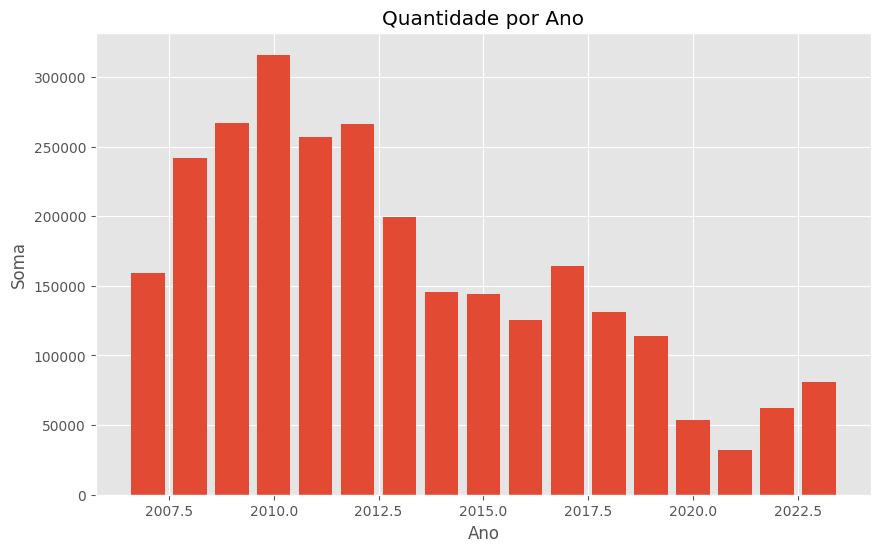

Ano  Quantidade
14  2021   32186.455
13  2020   53938.806
15  2022   62135.195
16  2023   81018.454
12  2019  114105.467
9   2016  125533.607
11  2018  131214.261
8   2015  144209.678
7   2014  145663.844
0   2007  158947.311
10  2017  164378.946
6   2013  199172.339
1   2008  242145.212
4   2011  256785.721
5   2012  265970.471
2   2009  266992.094
3   2010  316038.203

In [96]:
values = ['Quantidade']
sales_years = sales_data.groupby('Ano')[values].sum().reset_index()
sales_years = sales_years.sort_values(['Quantidade'], ascending=True)
plt.figure(figsize=(10, 6))
plt.bar(sales_years['Ano'], sales_years['Quantidade'])
plt.xlabel('Ano')
plt.ylabel('Soma')
plt.title('Quantidade por Ano')
plt.show()
sales_years

Qual é o volume financeiro de materiais vendidos durante o perído?

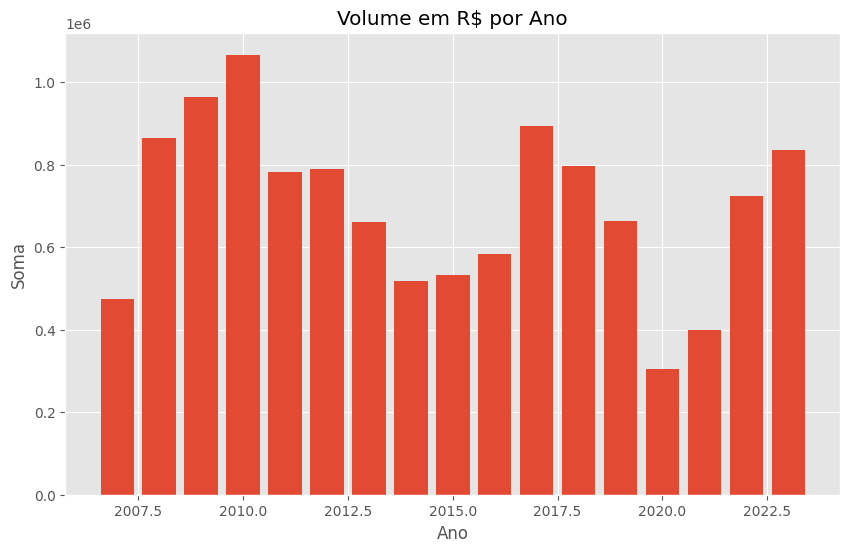

Ano         Total
0   2007  4.742683e+05
1   2008  8.658976e+05
2   2009  9.649191e+05
3   2010  1.067023e+06
4   2011  7.825292e+05
5   2012  7.910971e+05
6   2013  6.602411e+05
7   2014  5.176883e+05
8   2015  5.340294e+05
9   2016  5.827911e+05
10  2017  8.931892e+05
11  2018  7.964634e+05
12  2019  6.626127e+05
13  2020  3.038926e+05
14  2021  3.998505e+05
15  2022  7.254025e+05
16  2023  8.363072e+05

In [97]:
values = ['Total']
sales_years = sales_data.groupby('Ano')[values].sum().reset_index()
#sales_years = sales_years.sort_values(['Quantidade'], ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(sales_years['Ano'], sales_years['Total'])
plt.xlabel('Ano')
plt.ylabel('Soma')
plt.title('Volume em R$ por Ano')
plt.show()
sales_years

Qual é o melhor mês de vendas?

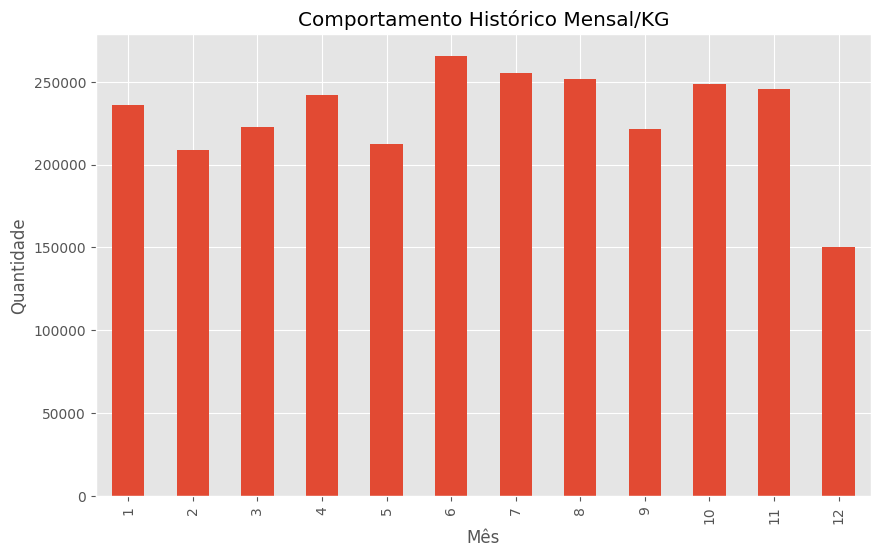

In [98]:
monthly_sales = sales_data.groupby('Mês')['Quantidade'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', title='Comportamento Histórico Mensal/KG')
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.show()


Qual é o dia com maior volume de faturamento?

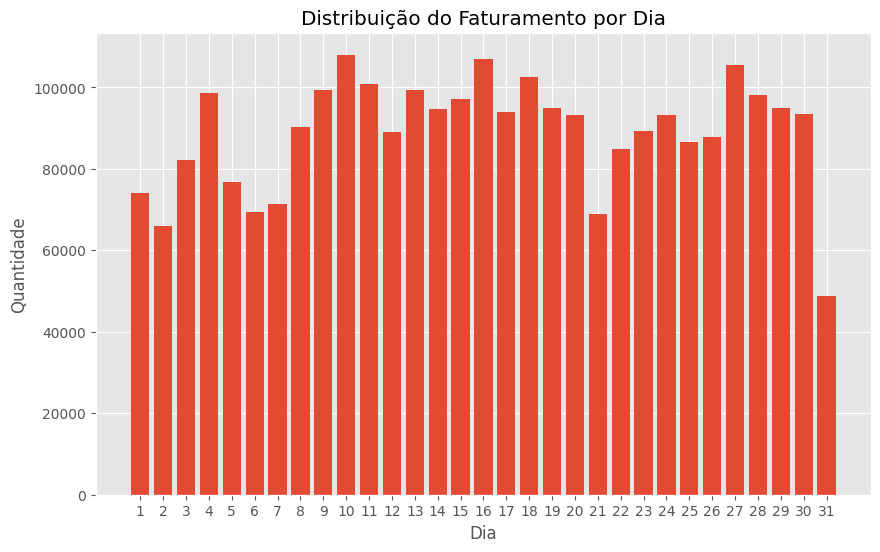

Dia  Quantidade
30   31   48784.520
1     2   65975.898
20   21   68831.031
5     6   69332.774
6     7   71347.047
0     1   74023.079
4     5   76761.842
2     3   82141.710
21   22   84946.737
24   25   86675.104
25   26   87928.496
11   12   89181.632
22   23   89224.336
7     8   90295.210
23   24   93126.477
19   20   93191.013
29   30   93547.897
16   17   93870.076
13   14   94711.360
18   19   94994.494
28   29   95056.825
14   15   97230.568
27   28   98126.329
3     4   98535.286
12   13   99308.557
8     9   99329.353
10   11  100967.224
17   18  102497.226
26   27  105583.103
15   16  106872.970
9    10  108037.890

In [99]:
sales_day = sales_data.groupby('Dia')[['Quantidade']].sum().reset_index()
sales_day = sales_day.sort_values(['Quantidade'], ascending=True)
# plot the sales by day
plt.figure(figsize=(10, 6))
plt.bar(sales_day['Dia'], sales_day['Quantidade'])
plt.xticks(sales_day['Dia'])
plt.ylabel('Quantidade')
plt.title('Distribuição do Faturamento por Dia')
plt.xlabel('Dia')
plt.show()
sales_day

Como é o volume acumulado de Familia de Produto?

<Figure size 1000x600 with 0 Axes>

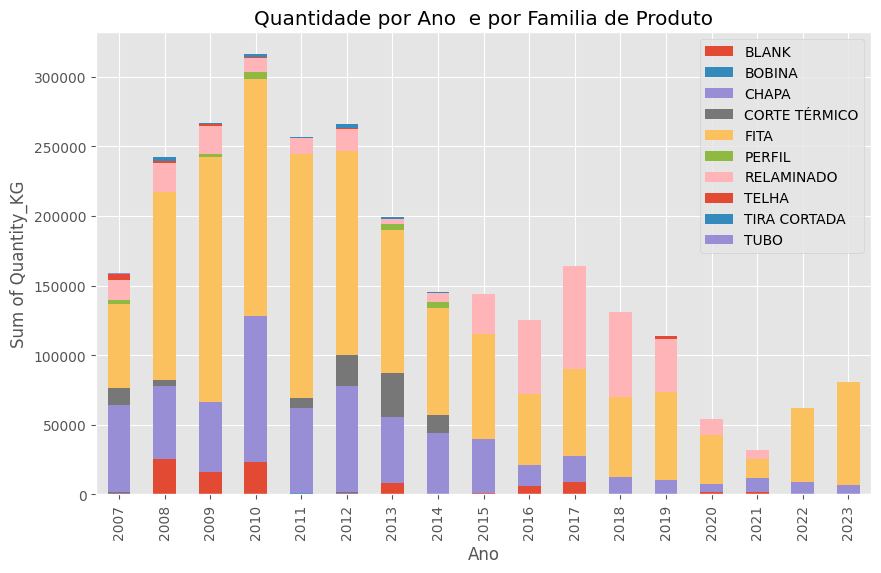

In [100]:
# Group and sum the data
grouped_data = sales_data.groupby(['Ano', 'Família Produto'])[['Quantidade']].sum().reset_index()
grouped_data = grouped_data.sort_values(['Quantidade'], ascending=False)
# Create a pivot table for better visualization
pivot_data = grouped_data.pivot(index='Ano', columns='Família Produto', values='Quantidade')
# Plot the pivot table
plt.figure(figsize=(10, 6))
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Ano')
plt.ylabel('Sum of Quantity_KG')
plt.title('Quantidade por Ano  e por Familia de Produto')
plt.legend()
plt.show()
#grouped_data

Qual é o produto campeão de vendas?

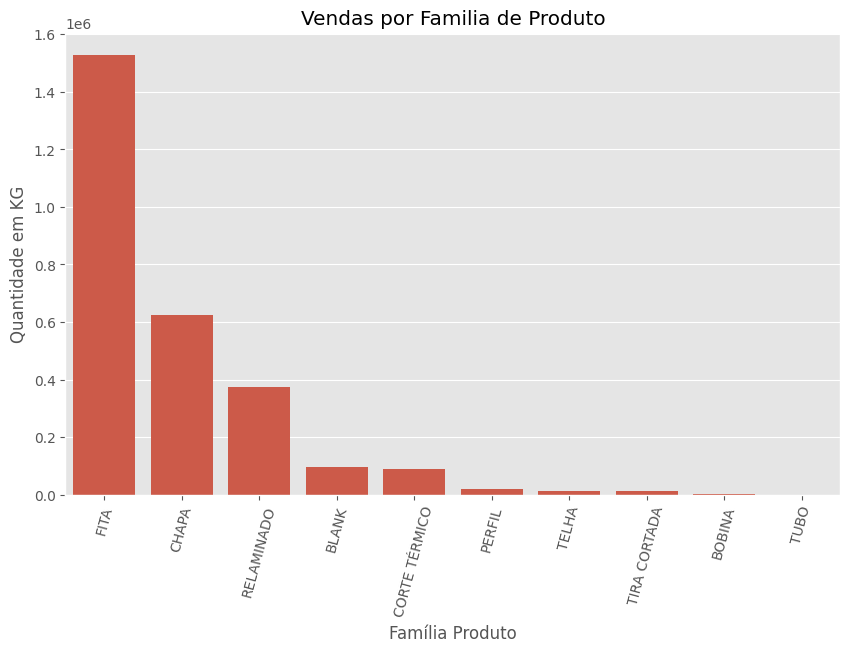

In [101]:
product_group = sales_data.groupby(['Família Produto'])
product_group_val = product_group['Quantidade'].sum().reset_index()
product_group_val = product_group_val.sort_values(['Quantidade'], ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Família Produto', y='Quantidade', data=product_group_val)
plt.xlabel('Família Produto')
plt.ylabel('Quantidade em KG')
plt.title('Vendas por Familia de Produto')
plt.xticks(rotation=75)
plt.show()

Quais são os diferentes tipos de fitas vendidas?

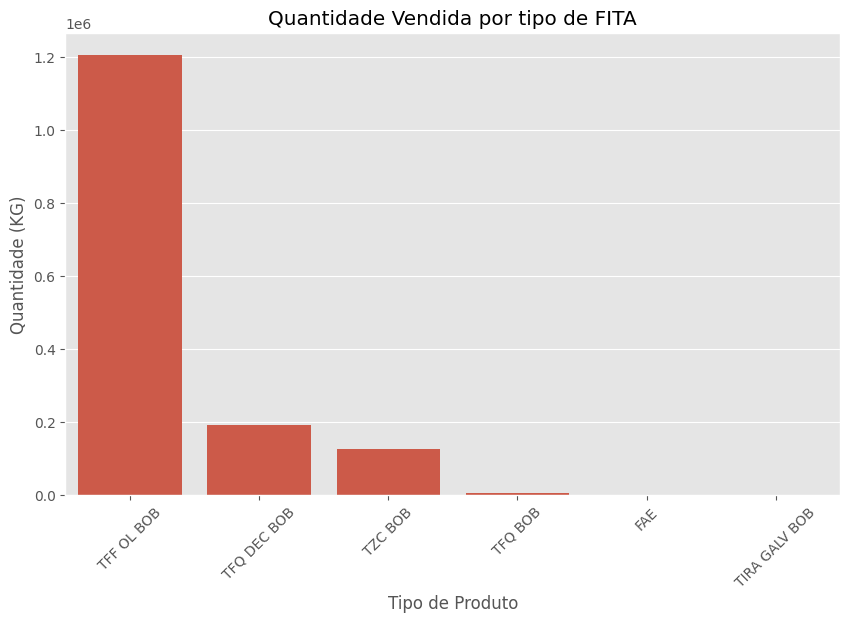

In [102]:
filtered_product = sales_data[sales_data['Família Produto'] == 'FITA']
filtered_product_val = filtered_product.groupby('Tipo de Produto')['Quantidade'].sum().reset_index()
filtered_product_val = filtered_product_val.sort_values(['Quantidade'], ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo de Produto', y='Quantidade', data=filtered_product_val)
plt.xlabel('Tipo de Produto')
plt.ylabel('Quantidade (KG)')
plt.title('Quantidade Vendida por tipo de FITA')
plt.xticks(rotation=45)
plt.show()

Qual é a frequência por tipo de Produto?

In [103]:
product_count = sales_data[['Tipo de Produto']].value_counts().to_frame()
product_count = product_count.rename(columns={0: 'Frequency'})
product_count.reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=product_count.index.get_level_values(0), y='Frequency', data=product_count)
plt.xlabel('Tipo de Produto')
plt.ylabel('Frequency')
plt.title('Frequencia por Tipo de Produto')
plt.xticks(rotation=90)
plt.show()

ValueError: Could not interpret value `Frequency` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

Qual é o valor total concentrado por Tipo de produto?

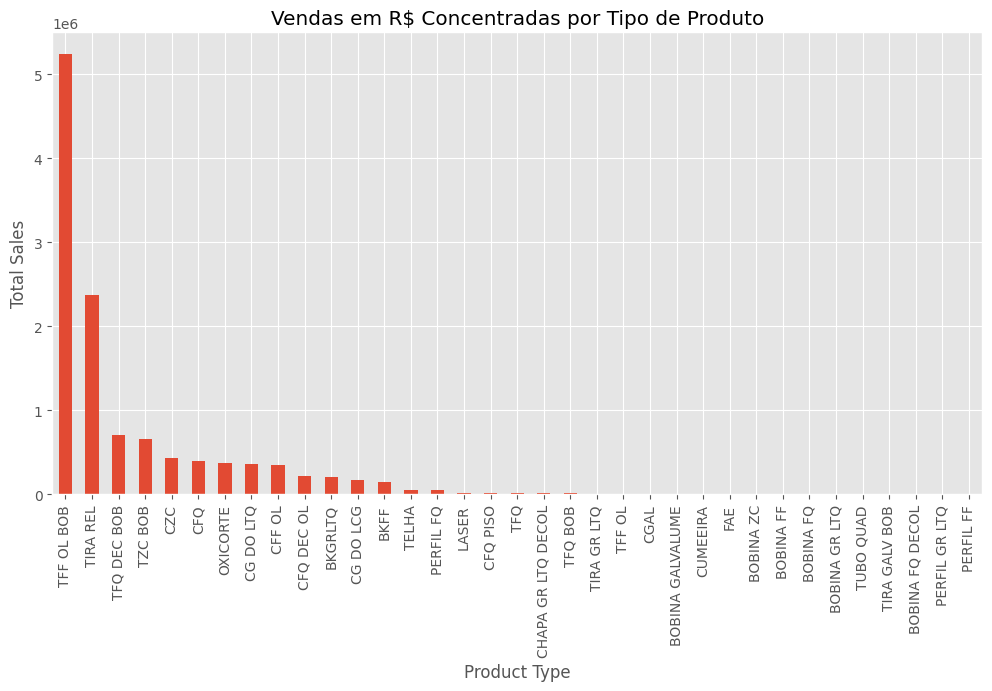

In [104]:
# Financial Analysis:

plt.figure(figsize=(12, 6))
sales_data.groupby('Tipo de Produto')['Total'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Vendas em R$ Concentradas por Tipo de Produto')
plt.xlabel('Product Type')
plt.ylabel('Total Sales')
plt.show()

Qual é a quantidade vendida por Família de produto?

In [105]:
# Group by 'Cliente' and sum the 'Quantidade'
quantidade_per_material = sales_data.groupby('Família Produto')['Quantidade'].sum().sort_values().reset_index()

# Print the DataFrame
quantidade_per_material

Família Produto   Quantidade
0            TUBO      235.000
1          BOBINA     2266.641
2    TIRA CORTADA    11038.241
3           TELHA    12112.925
4          PERFIL    18135.281
5   CORTE TÉRMICO    90452.540
6           BLANK    97467.983
7      RELAMINADO   375550.162
8           CHAPA   624088.179
9            FITA  1529089.112

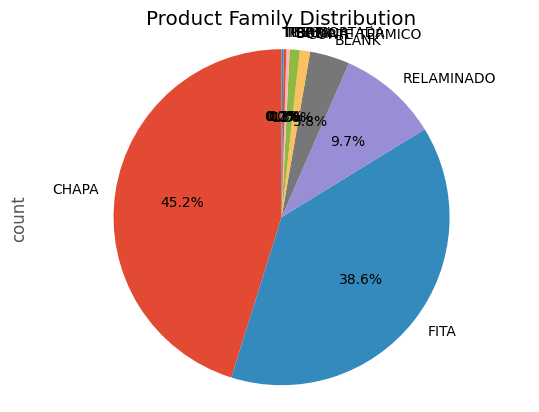

In [106]:
product_family_distribution = sales_data['Família Produto'].value_counts()
product_family_distribution.plot.pie(autopct='%1.1f%%', startangle=90, title='Product Family Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Qual é a quantidade vendida por Tipo de produto?

In [107]:
# Group by 'Cliente' and sum the 'Quantidade'
quantidade_per_material = sales_data.groupby('Tipo de Produto')['Quantidade'].sum().sort_values().reset_index()

# Print the DataFrame
quantidade_per_material

Tipo de Produto   Quantidade
0            PERFIL FF        3.530
1        PERFIL GR LTQ       13.669
2      BOBINA FQ DECOL       63.635
3        TIRA GALV BOB      122.915
4        BOBINA GR LTQ      175.305
5            TUBO QUAD      235.000
6             CUMEEIRA      365.000
7            BOBINA FQ      379.345
8     BOBINA GALVALUME      395.627
9            BOBINA ZC      521.870
10                 FAE      569.790
11           BOBINA FF      730.859
12                CGAL     1121.000
13              TFF OL     2041.000
14         TIRA GR LTQ     3946.797
15            CFQ PISO     4282.176
16                 TFQ     5050.444
17  CHAPA GR LTQ DECOL     5335.868
18             TFQ BOB     5791.093
19               LASER     7644.869
20               TELHA    11747.925
21           PERFIL FQ    18118.082
22           CG DO LCG    32277.492
23                BKFF    34045.612
24             BKGRLTQ    63422.371
25          CFQ DEC OL    78699.352
26            OXICORTE    82807.671
27              CFF OL   113524.775
28                 CZC   116231.763
29             TZC BOB   126851.418
30           CG DO LTQ   130079.450
31                 CFQ   142536.303
32         TFQ DEC BOB   190831.797
33            TIRA REL   375550.162
34          TFF OL BOB  1204922.099

Como é o volume de vendas por espessura?

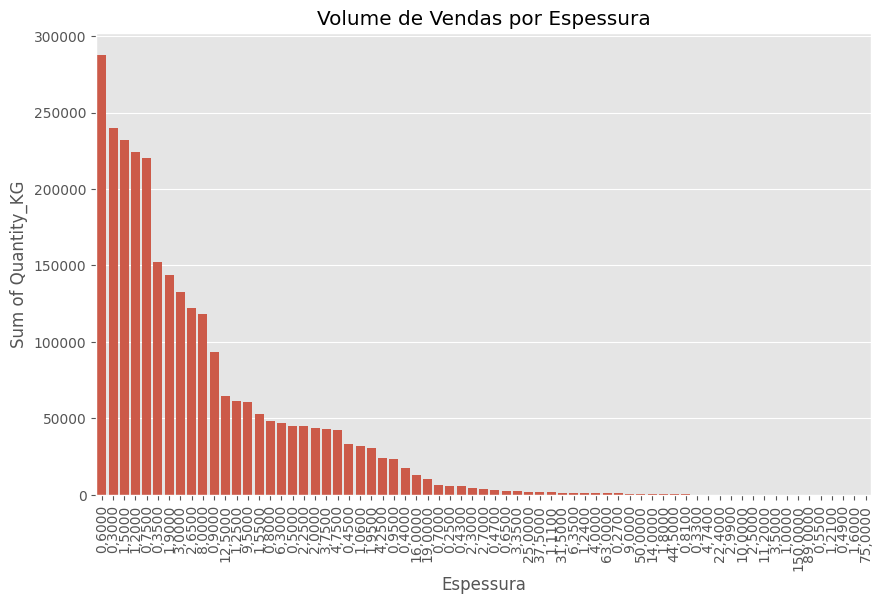

         Esp  Quantidade
12    0,6000  287606.885
2     0,3000  239931.380
27    1,5000  231847.319
23    1,2000  224277.067
15    0,7500  220491.346
4     0,3500  152027.787
31    1,9000  143937.464
49    3,0000  132919.680
44    2,6500  122213.227
65    8,0000  118100.289
18    0,9000   93356.368
35   12,5000   64606.032
26    1,2500   61618.106
68    9,5000   60589.144
28    1,5500   53039.642
16    0,8000   48170.833
61    6,3000   47264.345
10    0,5000   45336.303
41    2,2500   45246.613
40    2,0000   44068.507
52    3,7500   43024.200
58    4,7500   42152.911
7     0,4500   33137.931
21    1,0600   31699.554
32    1,9500   30529.890
56    4,2500   24152.355
19    0,9500   23573.211
5     0,4000   17722.920
38   16,0000   12800.061
39   19,0000   10399.053
14    0,7000    6453.218
0     0,2500    6097.355
6     0,4300    6063.041
42    2,3000    4268.413
45    2,7000    4131.874
8     0,4700    3400.001
13    0,6500    2868.926
50    3,3500    2723.777
48   25,0000    2023.789


In [108]:
quant_by_thick = sales_data.groupby('Esp')[['Quantidade']].sum().reset_index()
quant_by_thick = quant_by_thick.sort_values(['Quantidade'], ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Esp', y='Quantidade', data=quant_by_thick)
plt.xlabel('Espessura')
plt.ylabel('Sum of Quantity_KG')
plt.title('Volume de Vendas por Espessura')
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
plt.show()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(quant_by_thick)


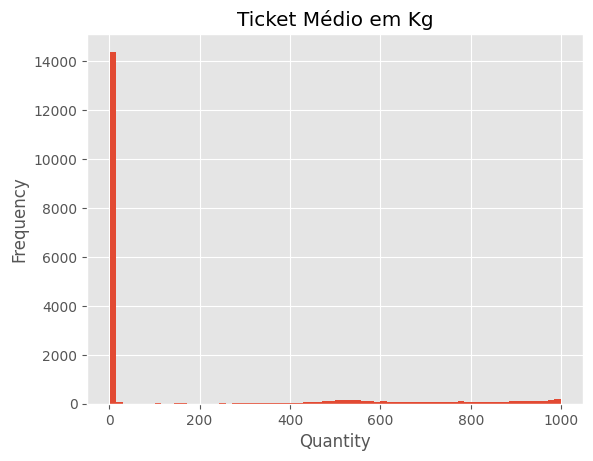

In [109]:
sales_data['Quantidade'].plot(kind='hist', bins=70, title='Ticket Médio em Kg')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

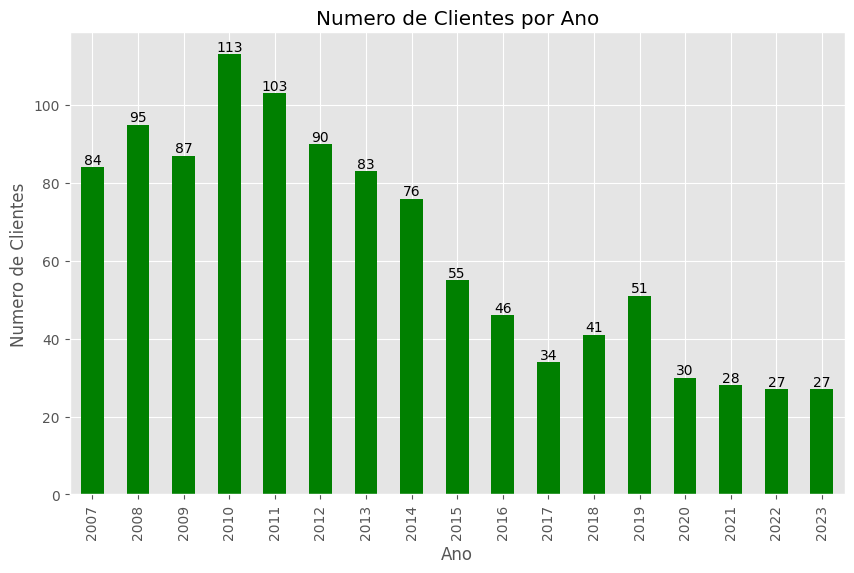

In [110]:
plt.figure(figsize=(10, 6))
clients_per_year = sales_data.groupby(['Ano'])['Cliente'].nunique()
clients_per_year.plot(kind='bar', color='green')
plt.title('Numero de Clientes por Ano')
plt.xlabel('Ano')
plt.ylabel('Numero de Clientes')
for i, value in enumerate(clients_per_year):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')
plt.show()

Qual é o volume de compras por cliente?

In [111]:
# Group by 'Cliente' and sum the 'Quantidade'
quantidade_per_cliente = sales_data.groupby('Cliente')['Quantidade'].sum().sort_values().reset_index()

# Print the DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(quantidade_per_cliente)

          Cliente  Quantidade
0       MILANOMOV       1.047
1        CORDATEX       1.065
2      SCARIOTMET       1.218
3     MACEDOBIOND       1.389
4     GILMARPEGOR       1.469
5      TECNOMETAL       1.608
6        BEMFATTO       1.729
7     LEAFARLOGIS       1.827
8            FAMM       2.045
9     MAGNUMETALU       2.064
10         ATHENA       2.091
11      METALBRIL       2.203
12     MILENIUMTR       2.250
13     DANFERLTDA       2.288
14    AGOSTINETTO       2.289
15     CRICELMONT       2.458
16        FAMCORP       2.795
17   ARQUITETARIA       2.855
18       MULTIFER       2.916
19            ASP       2.968
20          GEDOZ       2.982
21    TEDESCOLTDA       3.041
22    NONOFERRERO       3.405
23      SULTORRES       3.706
24      CASTERSUL       3.867
25          COBRA       3.889
26      DOSULINDE       4.577
27     FURGOKIT'S       4.602
28            PAG       4.718
29           GPER       4.754
30     EXPRESSOVR       4.952
31    MICHELEHAAB       4.974
32     DIM

Quais clientes não compram acima de 90 dias?

In [112]:
# Identify the last purchase date for each client
last_purchase_date = sales_data.groupby('Cliente')['Data'].max()

# Identify clients who haven't made a purchase in over 120 days
inactive_clients = last_purchase_date[last_purchase_date < pd.to_datetime('today') - pd.DateOffset(days=90)]

# Count the number of inactive clients
inactive_clients_count = inactive_clients.shape[0]

# Sort inactive clients by their last purchase date
inactive_clients_sorted = inactive_clients.sort_values()

# Print the count and sorted list of inactive clients
print(f"Number of clients with no purchase in over 90 days: {inactive_clients_count}")
print("Sorted list of inactive clients:")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(inactive_clients_sorted)

Number of clients with no purchase in over 90 days: 288
Sorted list of inactive clients:
Cliente
JKFERREIRA     2007-04-04
FAMM           2007-04-19
JARFLEX        2007-04-30
METSALVADOR    2007-05-18
GANADAL        2007-06-06
FORBAL         2007-06-12
HOFFMANN1      2007-06-12
UMBERTOBERT    2007-06-20
TECNOMETAL     2007-07-18
LINADALMORO    2007-08-09
IRMAOSLUVIS    2007-08-27
IRMAOSMOTA     2007-08-30
SULTORRES      2007-09-11
MDO            2007-10-05
DIMILANOPO     2007-10-11
IPE            2007-10-26
JRIND.2        2007-12-17
MDOLTDA        2008-01-04
BRANDA         2008-01-18
PROTECARTER    2008-01-18
JRIND.         2008-04-30
MILANOMOV      2008-05-28
KALIENT        2008-06-04
CCGL           2008-06-13
UTIL-LINE      2008-06-25
IECODESENVO    2008-06-25
MINERVA        2008-06-27
MULTIFER       2008-06-30
BRINDILUZ      2008-07-09
METALNOVA      2008-07-18
TESSAROIND     2008-08-19
SCHIFER        2008-10-03
GASTROLIDER    2008-10-15
RSCAXIAS       2008-10-30
REGIACOM       2008

# 7 Conclusão

Ao visualizar os dados, podemos obter uma compreensão mais profunda de sua distribuição em diferentes variáveis. Podemos examinar como as vendas se concentram em tipos específicos de produtos e espessuras, além de observar a variação de preço e volume ao longo do tempo. Percebemos uma correlação direta entre a taxa de câmbio do dólar o preço das matérias-primas. No entanto, para obter uma compreensão mais abrangente, seria benéfico incorporar outras variáveis econômicas e fatores adicionais de análise e predição, que possam servir como indicadores de flutuações de preços, problemas finaceiros e probabilidade de vendas.

Percebemos uma diminuição no volume das vendas de chapas que impactam diretamente o desempenho e embora não seja esplicito no relatório, a queda se deve, principalmente, a problemas financeiros e ao fechamento de empresas na Região, dentre elas, Rodare, Rodaros, Hidro Jet, Keko, Moferko, Perfilline, Metalcin, Engatcar, Vector, Luna...

A maior parte dos questiomentos iniciais permacem em aberto são objetos de aprofundamento deste trabalho.